***
# Mini Lab ML7331
> ### By Allen Hoskins, Brittany Lewandowski, Alexy Morris, Fidel Tamares


***

### COLOR MEANINGS:

> #### **Black:** Main Section Titles <br>
> #### <font color='Red'>Red:<font> Major Headings<br>
> #### <font color='Blue'>Blue: Model Types<font><br>
> #### <font color='Green'>Green: Original Data Set<font><br>
> #### <font color='Purple'>Purple: Undersampled Data Set<font><br>
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier,LogisticRegressionCV
from sklearn.feature_selection import SelectPercentile,f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time
import warnings

In [2]:
#run for final only
warnings.filterwarnings("ignore")

In [226]:
df = pd.read_csv(r'/Users/allen/Desktop/MSDS/ML1/archive/airline_merged.csv',low_memory=False)

In [4]:
pd.set_option('display.max_columns', None)

## <font color='Red'> Begin Data Preprocessing:<font>

After importing the merged file, airline_merged.csv, that was created in the ipynb file, airline_files_merge, we needed to remove the addditional column(Unnamed: 0) that is added in the export. 

In [227]:
#removing unwanted column from previous export
df = df.drop(columns =['Unnamed: 0'],axis =1)

The below cell creates a correlation matrix using all of the numerical columns and removes any column that has a correlation coeffecient that is greater than 0.90. This will eventually help decrease the amount of columns that are used in the model and help with any assumptions that need to be met.

In [228]:
#dropping highly correlated columns
#https://www.codegrepper.com/code-examples/python/how+to+drop+highly+correlated+features
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

df = df.drop(columns = to_drop, axis=1)

In [7]:
#looking at dataframe after removing highly correlated fields.
df.head()

,year,month,day,day_of_week,airline_cd,airline_name,flight_number,tail_number,origin_airport,airport_origin,city_origin,state_origin,country_origin,latitude_origin,longitude_origin,destination_airport,airport_destination,city_destination,state_destination,country_destination,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
0,2015,1,1,4,AS,Alaska Airlines Inc.,98,N407AS,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,5,-11.0,21.0,205.0,404.0,4.0,430,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,American Airlines Inc.,2336,N3KUAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,10,-8.0,12.0,280.0,737.0,4.0,750,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,US Airways Inc.,840,N171US,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,20,-2.0,16.0,286.0,800.0,11.0,806,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,American Airlines Inc.,258,N3HYAA,LAX,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,20,-5.0,15.0,285.0,748.0,8.0,805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,Alaska Airlines Inc.,135,N527AS,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,25,-1.0,11.0,235.0,254.0,5.0,320,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Since the data set is quite large and personal laptops will struggle to churn through the amount of rows and columns, we decided to filter down the data to Birmingham-Shuttlesworth International Airport. This decreased the data frame size from almost 6 million rows to just under 240k rows and also helped with the one hot encoding below.

In [229]:
#selecting subset of data set
airports = ['BHM']

In [230]:
df_air = df.loc[df['origin_airport'].isin(airports)]

In [10]:
df_air.describe()

,year,month,day,day_of_week,flight_number,latitude_origin,longitude_origin,latitude_destination,longitude_destination,scheduled_departure,departure_delay,taxi_out,scheduled_time,wheels_on,taxi_in,scheduled_arrival,diverted,cancelled,air_system_delay,security_delay,airline_delay,late_aircraft_delay,weather_delay
count,12514.0,12514.000000,12514.000000,12514.000000,12514.000000,1.251400e+04,1.251400e+04,12514.000000,12514.000000,12514.000000,12338.000000,12334.000000,12514.000000,12324.000000,12324.000000,12514.000000,12514.000000,12514.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000
mean,2015.0,6.150951,15.687710,3.879575,2876.476346,3.356294e+01,-8.675355e+01,34.252718,-88.175001,1192.116909,9.032906,13.783525,108.121864,1399.118306,8.632587,1416.011507,0.004075,0.014464,14.805921,0.091635,20.292293,27.732613,2.580827
std,0.0,3.384375,8.763785,1.992624,1951.952017,7.787860e-12,1.647104e-11,4.990106,8.325266,445.126945,43.869223,7.389709,36.974468,458.707388,5.844535,443.946518,0.063711,0.119397,32.820428,3.167858,73.036267,47.048389,16.190917
min,2015.0,1.000000,1.000000,1.000000,3.000000,3.356294e+01,-8.675355e+01,25.793250,-115.152330,500.000000,-20.000000,4.000000,52.000000,3.000000,1.000000,707.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,3.000000,8.000000,2.000000,1051.000000,3.356294e+01,-8.675355e+01,29.980470,-95.339720,745.000000,-5.000000,9.000000,76.000000,952.000000,5.000000,1009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.0,6.000000,16.000000,4.000000,2525.000000,3.356294e+01,-8.675355e+01,33.640440,-84.426940,1200.000000,-2.000000,12.000000,113.000000,1402.000000,7.000000,1414.000000,0.000000,0.000000,3.000000,0.000000,0.000000,9.000000,0.000000
75%,2015.0,9.000000,23.000000,5.000000,4592.000000,3.356294e+01,-8.675355e+01,39.175400,-83.348840,1609.000000,4.000000,16.000000,123.000000,1823.000000,10.000000,1825.000000,0.000000,0.000000,18.000000,0.000000,10.000000,34.000000,0.000000
max,2015.0,12.000000,31.000000,7.000000,6813.000000,3.356294e+01,-8.675355e+01,42.212060,-73.872610,2055.000000,1988.000000,116.000000,260.000000,2357.000000,150.000000,2325.000000,1.000000,1.000000,493.000000,144.000000,1971.000000,420.000000,240.000000


In [231]:
#selecting columns that are dtype != numeric
non_numeric = df_air.select_dtypes(exclude = np.number).columns

Because we want to predict if an airplane is going to be delayed or not using logistic regression, we created a new field called "is_delay" from the "departure_delay" field. To do this, we created a function that we could pass a numeric field through and if the value for that row is greater than 0, we imputed "1" into the curated field to signifiy the flight was delayed. If the value was less than 0, we imputed "0" to signify that the flight was not delayed. 

In [232]:
#create binary response for logistic regression
# create a function
def is_delayed(delay,axis=1):
    if delay <= 0:
        return 0
    else:
        return 1
    
# create a new column based on condition
df_air['is_delay'] = df_air.loc[:,'departure_delay'].apply(is_delayed)

After creating the "is_delay" field, we then began to One Hot Encode any categorial variables so that our model could interpret and use those columns. This caused a 12,514 by 38 data set to become 12,514 by 1777. 

In [233]:
#Departure Delay - response
#altered from https://www.statology.org/one-hot-encoding-in-python/

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore',drop='first')

#perform one-hot encoding on non-numeric column s
encoder_df = pd.DataFrame(encoder.fit_transform(df_air[non_numeric]).toarray())

#return column names from encoder
encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
encoded = df_air.join(encoder_df)

In [234]:
#drop original columns
final_df = encoded.drop(non_numeric, axis=1)

***
# <font color='Red'>Dealing With Unbalanced Response Variable:</font> 

> Because our response was unbalanced, we undersampled the data with a hypothesis that this would increase the accuracy of the model. As we find later in this workbook, we find that this is not the case.

0    8412
1    4102
Name: is_delay, dtype: int64


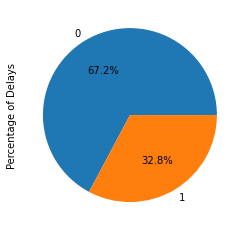

In [15]:
#Checking distribution of our response.
#The below code was altered from: https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/

print(final_df["is_delay"].value_counts())

final_df.groupby('is_delay').size().plot(kind='pie',
                                       y = "is_delay",
                                       label = "Percentage of Delays",
                                       autopct='%1.1f%%');

In [16]:
#creating 
zero_delay = final_df[final_df["is_delay"] == 0]
one_delay  = final_df[final_df["is_delay"] == 1]
print(zero_delay.shape)
print(one_delay.shape)

(8412, 1777)
(4102, 1777)


In [17]:
#Downsampling the response: "is_delay"
from sklearn.utils import resample

is_delay_downsample = resample(zero_delay,
             replace=True,
             n_samples=len(one_delay),
             random_state=42)

print(is_delay_downsample.shape)

(4102, 1777)


0    4102
1    4102
Name: is_delay, dtype: int64


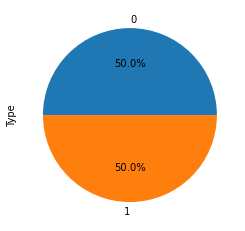

In [18]:
#Viewing that distribution has been downsampled.                               
data_downsampled = pd.concat([is_delay_downsample, one_delay])

print(data_downsampled["is_delay"].value_counts())

data_downsampled.groupby('is_delay').size().plot(kind='pie',
                                       y = "v1",
                                       label = "Type",
                                       autopct='%1.1f%%');

***
# <font color='Red'>Begin Modeling Data:<font>
From sklearn, we used their train_test_split package to create a 80/20 train and test split for our model.

***
### <font color='Green'>Test/Train Split for Original Data Set:<font>

> When creating the split between X and y data sets, we removed departure_delay as this column was what 'is_delay' was created from

In [235]:
#remove target variable and column target was created from training data set
target_cols = ['is_delay','departure_delay']
feature_cols = final_df.loc[:, ~final_df.columns.isin(target_cols)].columns
X = final_df[feature_cols] # Features
y = final_df.is_delay # Target variable

In [236]:
#split original dataset into features and target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)

In [237]:
#Separating feature columns and target variable into X and y variables for modeling.
Xd = data_downsampled[feature_cols] # Features
yd = data_downsampled.is_delay # Target variable

After one hot encoding, for our logistic regession model to run, we imputed the NaN values with 0.

In [238]:
#imputing 0 into NaN values for logistic regression after OHE
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

In [239]:
#checking shape of data
print('X_train shape: ',X_train.shape,'\n')
print('X_test shape: ',X_test.shape,'\n')
print('y_train shape: ',y_train.shape,'\n')
print('y_test shape: ',y_test.shape)

X_train shape:  (10011, 1775) 

X_test shape:  (2503, 1775) 

y_train shape:  (10011,) 

y_test shape:  (2503,)


***
### <font color='Purple'>Creating Test/Train for undersampled data:<font>

In [207]:
#Separating feature columns and target variable into X and y variables for modeling.
Xd = data_downsampled[feature_cols] # Features
yd = data_downsampled.is_delay # Target variable

In [208]:
#split downsampled dataset into features and target variable
Xd_train,Xd_test,yd_train,yd_test=train_test_split(Xd,yd,test_size=0.20,random_state=0)

In [209]:
#Imputing 0 into NaN values for logistic regression after OHE.
Xd_train = Xd_train.fillna(0)
Xd_test = Xd_test.fillna(0)
yd_train = yd_train.fillna(0)
yd_test = yd_test.fillna(0)

In [210]:
#checking shape of data
print('Xd_train shape: ',Xd_train.shape,'\n')
print('Xd_test shape: ',Xd_test.shape,'\n')
print('yd_train shape: ',yd_train.shape,'\n')
print('yd_test shape: ',yd_test.shape)

Xd_train shape:  (6563, 1775) 

Xd_test shape:  (1641, 1775) 

yd_train shape:  (6563,) 

yd_test shape:  (1641,)


***
# Logistic Regression and SVM Modeling:

## Evaluation Of Logistic Regression Model Performance:
> **Note:** Accuracy was used to identify our best model as it is a good metric to evaluate classification problems. In a real world example, other model metrics could be used to determine the best model.

***Our team built 4 logistic regression models for this lab:***
1. LR model one: Baseline logistic regression model with no feature selection or grid search applied.
2. LR model two: Logistic regression model using robust scaler, and SelectPercentile to select the top 30% of features for the model.
3. LR model three: Logistic regression model using GridSearch results to determine the best parameters to tune the model with.
4. LR model four: Logistic regression model using our under-sampled data frame with a robust scaler, and SelectPercentile for feature selection.

***Using an 80/20 train/test split on the models above, the following model metrics were obtained:***
1. LR model one:
    1. Accuracy: 0.831
    2. Precision: 0.964
    3. Recall: 0.482
2. LR model two:
    1. Accuracy: 0.836
    2. Precision: 0.989
    3. Recall: 0.483
3. LR model three:
    1. Accuracy: 0.836
    2. Precision: 0.989
    3. Recall: 0.483
4. LR model four(undersampled):
    1. Accuracy: 0.760
    2. Precision: 0.907
    3. Recall: 0.576

    
**Based on Accuracy alone the best LR model: Model 3**
 
## Evaluation Of SVM Model Performance:

**Our team built 4 SVM models for this lab:**
1. SVM model one: Baseline SVM model with no feature selection or grid search applied.
2. SVM model two: SVM using a robust scaler and SelectPercentile to select the top 30% of features in our model.
3. SVM model three: SVM using GridSearch results to select the best parameters to tune the model with.
4. SVM model four: SVM using our under-sampled data frame with a robust scaler and SelectPercentile for feature selection.

***Using an 80/20 train/test split on the models above, the following model metrics were obtained:***
1. SVM model one:
    1. Accuracy: 0.707
    2. Precision: 1.0
    3. Recall: 0.067
2. SVM model two:
    1. Accuracy: 0.815
    2. Precision: 0.413
    3. Recall: 0.413
3. SVM model three:
    1. Accuracy: 0.815
    2. Precision: 0.993
    3. Recall: 0.413
4. SVM model four(undersampled):
    1. Accuracy: 0.7471
    2. Precision: 0.9831
    3. Recall: 0.4994

    
**Based on Accuracy and Precision the best SVM model: Model 3**


## Parameters We Adjusted For LR & SVM Models:
The team fit models adjusting for the following parameters to try and produce better model metrics (Accuracy, Precision, Recall).

***Parameters Tried For Logistic Regression Models:***

Please note several of these parameters did not produce good model metrics and were not included in this markdown (MinMaxScaler, MaxAbsScaler). However, we did want to highlight the fact that we tried them.

1. Scaler = MinMaxScaler()
2. Scaler = MaxAbsScaler()
3. Scaler = Normalizer()
4. Scaler = Standard()
5. Penalty = l1
6. Penalty = l2
7. Penalty = elasticnet
8. class_weight = balanced
9. solver = sag
10. solver = saga
11. solver = liblinear

***Parameters Tried For SVM models using GridSeach:***
1. kernel = linear
2. kernel = rbf
3. decision_function_shape = ovo
4. decision_function_shape = ovr
5. gamma: scale
6. gamma: auto
7. class_weight: balanced

***
## <font color='Blue'>Logistic Regression Modeling:<font>

> ### **PCA was not used for feature selection as it created too many variables for our personal computer to handle.**

### <font color='Green'>Basic Logistic Regression Model for baseline:<font> 
> **Assumption:** Creating a base Logistic Regression model allowed us to determine if any model enhancements were beneficial.
    
>By running logistic regression models our team assumed that our data meets the following assumptions:
>- Independence of errors
>- Linearity in the logit for continuous variables
>- No multicollinearity
>- Lack of outliers

In [220]:
base_log_start = time.time()
basic_log = LogisticRegression(random_state = 0)
basic_fit = basic_log.fit(X_train,y_train)
base_log_end = time.time()
basic_ypred = basic_fit.predict(X_test)

base_runtime_lr = base_log_end - base_log_start

In [221]:
print('Start Logistic Regression Base Model Results:\n__________________________\n')
print('Runtime:\n',base_runtime_lr,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, basic_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, basic_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, basic_ypred),'\n')
print('End Logistic Regression Base Model Results\n__________________________\n')

Start Logistic Regression Base Model Results:
__________________________

Runtime:
 0.9201369285583496 

Accuracy:
 0.8318018377946464 

Precision:
 0.9643765903307888 

Recall:
 0.4821882951653944 

End Logistic Regression Base Model Results
__________________________



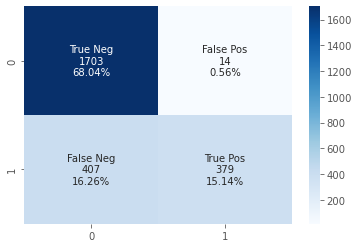

In [222]:
#basic Confusion Matrix
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
basic_cf_matrix = confusion_matrix(y_test, basic_ypred)

basic_group_names = ['True Neg','False Pos','False Neg','True Pos']

basic_group_counts = ["{0:0.0f}".format(value) for value in
                basic_cf_matrix.flatten()]

basic_group_percentages = ["{0:.2%}".format(value) for value in
                     basic_cf_matrix.flatten()/np.sum(basic_cf_matrix)]

basic_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(basic_group_names,basic_group_counts,basic_group_percentages)]

basic_labels = np.asarray(basic_labels).reshape(2,2)

sns.heatmap(basic_cf_matrix, annot=basic_labels, fmt='', cmap='Blues');

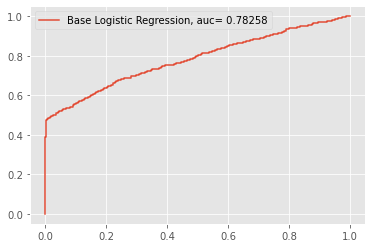

In [223]:
#ROC Curve
basic_ypred_proba = basic_fit.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  basic_ypred_proba)
basic_lr_auc = metrics.roc_auc_score(y_test, basic_ypred_proba)
plt.plot(fpr,tpr,label="Base Logistic Regression, auc= "+str(round(basic_lr_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using Robust scaler and selecting top 30% of features in Logistic Regression Model:<font>
> **Assumption:** Scaling and only selecting the top 30% of features in the model should positively impact the model and create a higher percentage as we would potentially be not overfitting the model.

In [102]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler = RobustScaler()

logistic = LogisticRegression(random_state = 0)

f_select = SelectPercentile(score_func = f_regression,percentile = 30)

fselect_lr_start = time.time()
fselect_lr_pipe = Pipeline(steps=[("scaler", scaler),
                       ('f_select', f_select),
                       ("logistic", logistic)]
               )
fselect_lr_end = time.time()
fselect_lr_pipe.fit(X_train,y_train)

fselect_lr_runtime =fselect_lr_end - fselect_lr_start

After fitting the model, we then ran our test data set through to create predictions.

In [103]:
#predict
fselect_lr_ypred=fselect_lr_pipe.predict(X_test)

After creating predictions on our test data set, we pulled metrics to determine how well our model performed. Our base model had an accuracy of 78.31% with a precision of 95.99% and a recall of 51.54%. This model output gives us a good starting point for hypertuing the model and comparison against some more powerful models such as XGBoost or LightGBM. After computing these metrics we then created a confusion matrix heatmap to better visualize how well our model was predicting and where the model could perform better with False Positives and False Negatives.

In [104]:
print('Start Scaled and Trimmed Logistic Regression Model Results:\n__________________________\n')
print('Runtime:\n',fselect_lr_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, fselect_lr_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, fselect_lr_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, fselect_lr_ypred),'\n')
print('End Scaled and Trimmed Logistic Regression Model Results\n__________________________\n')

Start Scaled and Trimmed Logistic Regression Model Results:
__________________________

Runtime:
 0.0003428459167480469 

Accuracy:
 0.8357970435477428 

Precision:
 0.9947229551451188 

Recall:
 0.4796437659033079 

End Scaled and Trimmed Logistic Regression Model Results
__________________________



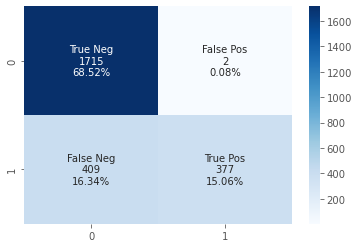

In [105]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
fselect_lr_cf_matrix = confusion_matrix(y_test, fselect_lr_ypred)

fselect_lr_group_names = ['True Neg','False Pos','False Neg','True Pos']

fselect_lr_group_counts = ["{0:0.0f}".format(value) for value in
                fselect_lr_cf_matrix.flatten()]

fselect_lr_group_percentages = ["{0:.2%}".format(value) for value in
                     fselect_lr_cf_matrix.flatten()/np.sum(fselect_lr_cf_matrix)]

fselect_lr_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(fselect_lr_group_names,
              fselect_lr_group_counts,
              fselect_lr_group_percentages)]

fselect_lr_labels = np.asarray(fselect_lr_labels).reshape(2,2)

sns.heatmap(fselect_lr_cf_matrix, annot=fselect_lr_labels, fmt='', cmap='Blues');

Finally we chose to plot a ROC curve to visualize specificity and sensitiviy of our model. 

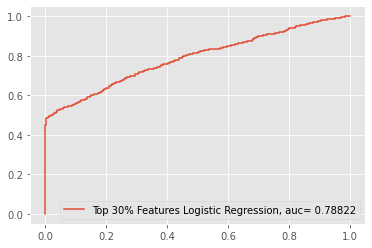

In [106]:
#ROC Curve
fselect_lr_ypred_proba = fselect_lr_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  fselect_lr_ypred_proba)
fselect_lr_auc = metrics.roc_auc_score(y_test, fselect_lr_ypred_proba)
plt.plot(fpr,tpr,label="Top 30% Features Logistic Regression, auc= "+str(round(fselect_lr_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using GridSearchCV to determine best parameters to tune the Logistic Regression model:<font>
> **Assumption:** Using GridSearchCV in theory will help us hypertune the model to find the best parameters. These parameters will then be used in the model so that we will increase accuracy and present the best model possible.
    
**GridSearchCV Returned Metrics:**
1) C: **1.0**
2) Penalty: **l2**
3) Solver: **liblinear**

In [37]:
# Grid search cross validation

lr_grid={"C":np.logspace(-3,3,7), 
      "penalty":["l1","l2"],
      'solver': ['saga','lbfgs','sag','liblinear']}# l1 lasso l2 ridge
start_grid_lr = time.time()
model_lr=LogisticRegression(random_state = 0)
logreg_cv=GridSearchCV(model_lr,
                       lr_grid,
                       cv=10)
end_grid_lr = time.time()
logreg_cv.fit(X_train,y_train)

print('GridSearchCV Metrics:\n__________________________\n')
print('Tuned hpyerparameters :(best parameters) ',logreg_cv.best_params_)
print('Accuracy :',logreg_cv.best_score_)
print('GridSearch Runtime:',end_grid_lr-start_grid_lr)
print('\nEnd GridSearchCV Metrics\n__________________________\n')

GridSearchCV Metrics:
__________________________

Tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy : 0.8243934708006565
GridSearch Runtime: 6.604194641113281e-05

End GridSearchCV Metrics
__________________________



***
### <font color = 'Green'>Using Tuned Parameters in Scaled/Trimmed regression pipeline:<font>
> **Assumptions:** The following model uses the parameters returned from GridSearchCV, this model in theory would perform the best out of all of our previous models.

In [240]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a pipeline to search for the best combination of PCA truncation

# Define a Standard Scaler to normalize inputs
scaler = RobustScaler()
tuned_c = 1.0
tuned_penalty = 'l2'
tuned_solver = 'liblinear'

logistic = LogisticRegression(random_state = 0,
                             C = tuned_c,
                             penalty = tuned_penalty,
                             solver = tuned_solver)

tuned_fselect_lr_start = time.time()
f_select = SelectPercentile(score_func = f_regression,percentile = 30)

tuned_fselect_lr_pipe = Pipeline(steps=[("scaler", scaler),
                                        ('f_select', f_select),
                                        ("logistic", logistic)
                                       ]
                                )
tuned_fselect_lr_pipe.fit(X_train,y_train)
tuned_fselect_lr_end = time.time()
tuned_fselect_lr_runtime = tuned_fselect_lr_end - tuned_fselect_lr_start

In [242]:
#predict
tuned_fselect_lr_ypred=tuned_fselect_lr_pipe.predict(X_test)

In [243]:
print('Start Scaled and Trimmed Logistic Regression Model Results:\n__________________________\n')
print('Runtime:\n',tuned_fselect_lr_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(y_test, tuned_fselect_lr_ypred),'\n')
print('Precision:\n',metrics.precision_score(y_test, tuned_fselect_lr_ypred),'\n')
print('Recall:\n',metrics.recall_score(y_test, tuned_fselect_lr_ypred),'\n')
print('End Scaled and Trimmed Logistic Regression Model Results\n__________________________\n')

Start Scaled and Trimmed Logistic Regression Model Results:
__________________________

Runtime:
 0.4045259952545166 

Accuracy:
 0.8361965641230523 

Precision:
 0.9895833333333334 

Recall:
 0.48346055979643765 

End Scaled and Trimmed Logistic Regression Model Results
__________________________



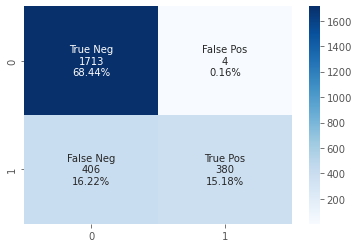

In [244]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
tuned_fselect_lr_cf_matrix = confusion_matrix(y_test, tuned_fselect_lr_ypred)

tuned_fselect_lr_group_names = ['True Neg','False Pos','False Neg','True Pos']

tuned_fselect_lr_group_counts = ["{0:0.0f}".format(value) for value in
                tuned_fselect_lr_cf_matrix.flatten()]

tuned_fselect_lr_group_percentages = ["{0:.2%}".format(value) for value in
                     tuned_fselect_lr_cf_matrix.flatten()/np.sum(tuned_fselect_lr_cf_matrix)]

tuned_fselect_lr_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(tuned_fselect_lr_group_names,
              tuned_fselect_lr_group_counts,
              tuned_fselect_lr_group_percentages)]

tuned_fselect_lr_labels = np.asarray(tuned_fselect_lr_labels).reshape(2,2)

sns.heatmap(tuned_fselect_lr_cf_matrix,
            annot=tuned_fselect_lr_labels,
            fmt='',
            cmap='Blues');

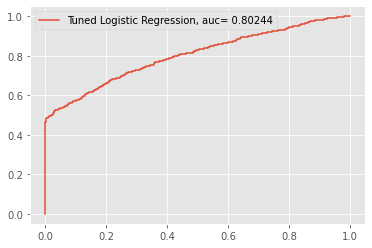

In [245]:
#ROC Curve
tuned_fselect_lr_ypred_proba = tuned_fselect_lr_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  tuned_fselect_lr_ypred_proba)
tuned_fselect_lr_auc = metrics.roc_auc_score(y_test, tuned_fselect_lr_ypred_proba)
plt.plot(fpr,tpr,label="Tuned Logistic Regression, auc= "+str(round(tuned_fselect_lr_auc,5)))
plt.legend(loc=0)
plt.show();

***
# <font color='Blue'>SVM Modeling:<font>
    


### <font color='Green'>Basic SVM Model for Baseline:<font>

> **Assumption:** Creating a base SVM model allowed us to determine if any model enhancements were beneficial.

***

In [112]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Scale -> PCA -> LR 
base_svc = SVC(random_state = 0,
               probability=True)


start_base_svc = time.time()
base_svc.fit(X_train,y_train)
end_base_svc = time.time()

#predict
base_ypred_svc=base_svc.predict(X_test)

base_runtime_svc = end_base_svc-start_base_svc
accuracy_svc = metrics.accuracy_score(y_test,base_ypred_svc)
precision_svc = metrics.precision_score(y_test, base_ypred_svc)
recall_svc = metrics.recall_score(y_test, base_ypred_svc)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',base_runtime_svc,'\n')
print('Accuracy:\n',accuracy_svc,'\n')
print('Precision:\n',precision_svc,'\n')
print('Recall:\n',recall_svc,'\n')
print('End SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 333.0092170238495 

Accuracy:
 0.7071514182980424 

Precision:
 1.0 

Recall:
 0.06743002544529263 

End SVM Base Model Results
__________________________



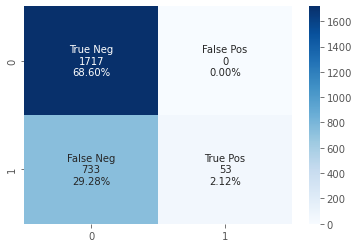

In [113]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_base_svm = confusion_matrix(y_test, base_ypred_svc)

group_names_base_svm = ['True Neg','False Pos','False Neg','True Pos']

group_counts_base_svm = ["{0:0.0f}".format(value) for value in
                cf_matrix_base_svm.flatten()]

group_percentages_base_svm = ["{0:.2%}".format(value) for value in
                     cf_matrix_base_svm.flatten()/np.sum(cf_matrix_base_svm)]

labels_base_svm = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_base_svm,
              group_counts_base_svm,
              group_percentages_base_svm)]

labels_base_svm = np.asarray(labels_base_svm).reshape(2,2)

sns.heatmap(cf_matrix_base_svm, annot=labels_base_svm, fmt='', cmap='Blues');

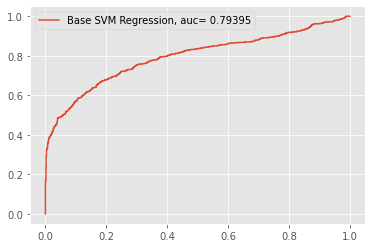

In [114]:
#ROC Curve
base_svc_ypred_proba = base_svc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  base_svc_ypred_proba)
base_svc_auc = metrics.roc_auc_score(y_test, base_svc_ypred_proba)
plt.plot(fpr,tpr,label="Base SVM Regression, auc= "+str(round(base_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using Robust scaler and selecting top 30% of features in SVM Model:<font>
> **Assumption:** Scaling and only selecting the top 30% of features in the SVM model should positively impact the model and create a higher percentage as we would potentially be not overfitting the model.

In [115]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

fselect_scaler_svc = RobustScaler()

fselect_svc = SVC(random_state = 0,
                 probability=True)

f_select_svc = SelectPercentile(score_func = f_regression,
                                percentile = 30)

fselect_svc_pipe = Pipeline(steps=[('scaler', fselect_scaler_svc),
                                   ('f_select', f_select_svc),
                                   ("SVM", fselect_svc)]
               )

start_fselect_svm = time.time()
fselect_svc_pipe.fit(X_train,y_train)
end_fselect_svm = time.time()

#predict
fselect_ypred_svm = fselect_svc_pipe.predict(X_test)

#metrics
runtime_svm_fselect = end_fselect_svm - start_fselect_svm
accuracy_svm_fselect = metrics.accuracy_score(y_test,fselect_ypred_svm)
precision_svm_fselect = metrics.precision_score(y_test, fselect_ypred_svm)
recall_svm_fselect = metrics.recall_score(y_test, fselect_ypred_svm)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',runtime_svm_fselect,'\n')
print('Accuracy:\n',accuracy_svm_fselect,'\n')
print('Precision:\n',recall_svm_fselect,'\n')
print('Recall:\n',recall_svm_fselect,'\n')
print('End SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 72.91187715530396 

Accuracy:
 0.8150219736316421 

Precision:
 0.41348600508905853 

Recall:
 0.41348600508905853 

End SVM Base Model Results
__________________________



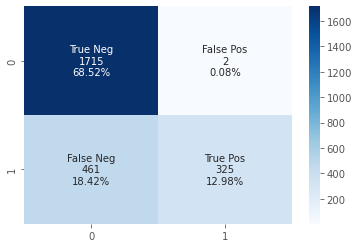

In [116]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_fselect_svm = confusion_matrix(y_test, fselect_ypred_svm)

group_names_fselect_svm = ['True Neg','False Pos','False Neg','True Pos']

group_counts_fselect_svm = ["{0:0.0f}".format(value) for value in
                cf_matrix_fselect_svm.flatten()]

group_percentages_fselect_svm = ["{0:.2%}".format(value) for value in
                     cf_matrix_fselect_svm.flatten()/np.sum(cf_matrix_fselect_svm)]

labels_fselect_svm = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_fselect_svm,
              group_counts_fselect_svm,
              group_percentages_fselect_svm)]

labels_fselect_svm = np.asarray(labels_fselect_svm).reshape(2,2)

sns.heatmap(cf_matrix_fselect_svm,
            annot=labels_fselect_svm,
            fmt='', 
            cmap='Blues');

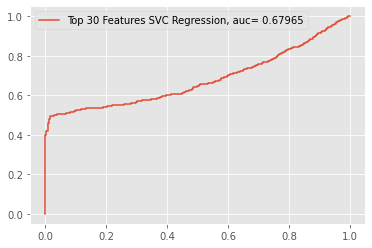

In [117]:
#ROC Curve
fselect_svc_ypred_proba = fselect_svc_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  fselect_svc_ypred_proba)
fselect_svc_auc = metrics.roc_auc_score(y_test, fselect_svc_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(fselect_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Green'>Using GridSearchCV to determine best parameters to tune the SVC model:<font>
    
> **Assumption:** Using GridSearchCV in theory will help us hypertune the model to find the best parameters. These parameters will then be used in the model so that we will increase accuracy and present the best model possible.
    

**GridSearchCV Returned Metrics:**
1) Kernel: **NA**
2) Decision Function Shape: **ovo**
3) Gamma: **auto**
4) Class Weight:**balanced**

In [53]:
svc_tune_parameters = {
                        'kernel':['linear', 'rbf'],
                        'decision_function_shape':['ovo', 'ovr'],
                        'gamma': ['scale','auto'],
                        'class_weight': ['balanced']
                    }

svc_model = SVC(random_state = 0)

grid_search_svc_tune = GridSearchCV(estimator=svc_model,
                                      param_grid=svc_tune_parameters,
                                      scoring = 'accuracy')

start_svc_tune = time.time()
grid_search_svc_tune.fit(X_train, y_train)
end_svc_tune = time.time()

print('GridSearchCV Results:\n__________________________\n')
print(
    "GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
    % (end_svc_tune - start_svc_tune, len(grid_search_svc_tune.cv_results_["params"]))
)
print('GSCV Best Estimator:\n',grid_search_svc_tune.best_estimator_,'\n')
print('GSCV Best Score:\n',grid_search_svc_tune.best_score_,'\n')
print('\nEnd GridSearchCV Results\n__________________________\n')

GridSearchCV Results:
__________________________

GridSearchCV took 6534.82 seconds for 8 candidate parameter settings.

GSCV Best Estimator:
 SVC(class_weight='balanced', decision_function_shape='ovo', gamma='auto',
    random_state=0) 

GSCV Best Score:
 0.802517851594237 


End GridSearchCV Results
__________________________



***
### <font color = 'Green'>SVC Model using Tuned Parameters:<font>

> **Assumptions:** The following model uses the parameters returned from GridSearchCV, this model in theory would perform the best out of all of our previous models.

In [305]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

svc_scaler = RobustScaler()

dfs_svc_tuned = 'ovo'
gamma_tuned = 'auto'
class_weight_tuned = 'balanced'

tuned_fselect_svc = SVC(random_state = 0,
                        probability=True,
                        decision_function_shape = dfs_svc_tuned,
                        gamma = gamma_tuned,
                        class_weight = class_weight_tuned
                        )

tuned_f_select_svc = SelectPercentile(score_func = f_regression,
                                        percentile = 30)

tuned_fselect_svc_pipe = Pipeline(steps=[('scaler', svc_scaler),
                                         ('f_select', f_select_svc),
                                         ("SVM", fselect_svc)]
                                )

tuned_start_fselect_svm = time.time()
tuned_fselect_svc_pipe.fit(X_train,y_train)
tuned_end_fselect_svm = time.time()

#predict
tuned_fselect_ypred_svm=tuned_fselect_svc_pipe.predict(X_test)

tuned_runtime_svm_fselect = tuned_end_fselect_svm - tuned_start_fselect_svm
tuned_accuracy_svm_fselect = metrics.accuracy_score(y_test,tuned_fselect_ypred_svm)
tuned_precision_svm_fselect = metrics.precision_score(y_test, tuned_fselect_ypred_svm)
tuned_recall_svm_fselect = metrics.recall_score(y_test, tuned_fselect_ypred_svm)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',tuned_runtime_svm_fselect,'\n')
print('Accuracy:\n',tuned_accuracy_svm_fselect,'\n')
print('Precision:\n',tuned_precision_svm_fselect,'\n')
print('Recall:\n',tuned_recall_svm_fselect,'\n')
print('\nEnd SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 86.10371494293213 

Accuracy:
 0.8150219736316421 

Precision:
 0.9938837920489296 

Recall:
 0.41348600508905853 


End SVM Base Model Results
__________________________



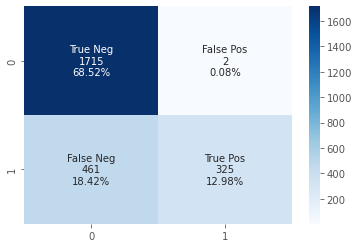

In [306]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_fselect_svm_tuned = confusion_matrix(y_test, tuned_fselect_ypred_svm)

group_names_fselect_svm_tuned = ['True Neg','False Pos','False Neg','True Pos']

group_counts_fselect_svm_tuned = ["{0:0.0f}".format(value) for value in
                cf_matrix_fselect_svm_tuned.flatten()]

group_percentages_fselect_svm_tuned = ["{0:.2%}".format(value) for value in
                     cf_matrix_fselect_svm_tuned.flatten()/np.sum(cf_matrix_fselect_svm_tuned)]

labels_fselect_svm_tuned = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_fselect_svm_tuned,
              group_counts_fselect_svm_tuned,
              group_percentages_fselect_svm_tuned)]

labels_fselect_svm_tuned = np.asarray(labels_fselect_svm_tuned).reshape(2,2)

sns.heatmap(cf_matrix_fselect_svm_tuned,
            annot=labels_fselect_svm_tuned,
            fmt='', 
            cmap='Blues');

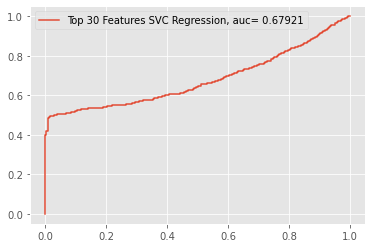

In [307]:
#ROC Curve
tuned_fselect_svc_ypred_proba = tuned_fselect_svc_pipe.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  tuned_fselect_svc_ypred_proba)
tuned_fselect_svc_auc = metrics.roc_auc_score(y_test, tuned_fselect_svc_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(tuned_fselect_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
## <font color = 'Red'>Undersampled Models:<font><br>

> **Assumptions:** Due to the unbalanced response variable in our data, we performed both Logistic Regression and SVM models on an under-sampled data set. This was due to the assumption that balancing the data set would increase accuracy and model performance. We used the GridSearchCV results for both models.

### <font color = 'Purple'>Undersampled Logistic Regression Model:<font>

In [311]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

# Define a Standard Scaler to normalize inputs
scaler_und = RobustScaler()

tuned_c_und = 1.0
tuned_penalty_und = 'l2'
tuned_solver_und = 'liblinear'

logisti_undc = LogisticRegression(random_state = 0,
                             C = tuned_c_und,
                             penalty = tuned_penalty_und,
                             solver = tuned_solver_und)

f_und = SelectPercentile(score_func = f_regression,
                                percentile = 30)

lr_und_start = time.time()
lr_und = Pipeline(steps=[("scaler", scaler_und),
                       ('f_select', f_und),
                       ("logistic", logistic_und)]
               )
lr_und_end = time.time()
lr_und_runtime = lr_und_end - lr_und_start
lr_und.fit(Xd_train,yd_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('f_select',
                 SelectPercentile(percentile=30,
                                  score_func=<function f_regression at 0x7fb7126a2430>)),
                ('logistic', LogisticRegression(random_state=0))])

In [312]:
#predict
lr_und_ypred=lr_und.predict(Xd_test)

In [313]:
#print results 
print('Start Logistic Regression Undersampled Base Model Results:\n__________________________\n')
print('Runtime:\n',lr_und_runtime,'\n')
print('Accuracy:\n',metrics.accuracy_score(yd_test, lr_und_ypred),'\n')
print('Precision:\n',metrics.precision_score(yd_test, lr_und_ypred),'\n')
print('Recall:\n',metrics.recall_score(yd_test, lr_und_ypred),'\n')
print('End Logistic Regression Undersampled Base Model Results\n__________________________\n')

Start Logistic Regression Undersampled Base Model Results:
__________________________

Runtime:
 0.0002620220184326172 

Accuracy:
 0.7599024984765387 

Precision:
 0.90715667311412 

Recall:
 0.5754601226993865 

End Logistic Regression Undersampled Base Model Results
__________________________



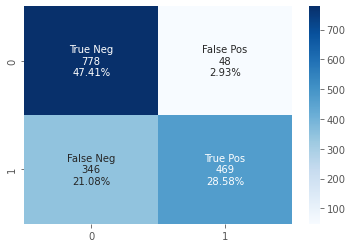

In [314]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
lr_und__cf_matrix = confusion_matrix(yd_test, lr_und_ypred)

lr_und_group_names = ['True Neg','False Pos','False Neg','True Pos']

lr_und_group_counts = ["{0:0.0f}".format(value) for value in
                lr_und__cf_matrix.flatten()]

lr_und_group_percentages = ["{0:.2%}".format(value) for value in
                     lr_und__cf_matrix.flatten()/np.sum(lr_und__cf_matrix)]

lr_und_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(lr_und_group_names,
              lr_und_group_counts,
              lr_und_group_percentages)]

lr_und_labels = np.asarray(lr_und_labels).reshape(2,2)

sns.heatmap(lr_und__cf_matrix,
            annot=lr_und_labels,
            fmt='',
            cmap='Blues');

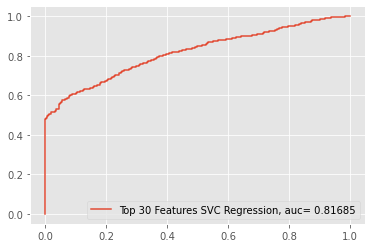

In [315]:
#ROC Curve
lr_und_ypred_proba = lr_und.predict_proba(Xd_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yd_test,  lr_und_ypred_proba)
lr_und_svc_auc = metrics.roc_auc_score(yd_test, lr_und_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(lr_und_svc_auc,5)))
plt.legend(loc=0)
plt.show();

***
### <font color = 'Purple'>Undersampled SVM model<font>
***

In [308]:
#https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a

svm_und_scaler = RobustScaler()

dfs_svc_tuned_und = 'ovo'
gamma_tuned_und = 'auto'
class_weight_tuned_und = 'balanced'


fselect_svc_und = SVC(random_state = 0,
                      probability=True,
                      decision_function_shape = dfs_svc_tuned_und,
                      gamma = gamma_tuned_und,
                      class_weight = class_weight_tuned_und)

f_select_svc_und = SelectPercentile(score_func = f_regression,
                                percentile = 30)

fselect_svc_und_pipe = Pipeline(steps=[('scaler',svm_und_scaler),
                       ('f_select', f_select_svc_und),
                       ("SVM", fselect_svc_und)]
               )

start_fselect_svm_und = time.time()
fselect_svc_und_pipe.fit(Xd_train,yd_train)
end_fselect_svm_und = time.time()

#predict
fselect_ypred_svm_und = fselect_svc_und_pipe.predict(Xd_test)

runtime_svm_und_fselect = end_fselect_svm - start_fselect_svm
accuracy_svm_und_fselect = metrics.accuracy_score(yd_test,fselect_ypred_svm_und)
precision_svm_und_fselect = metrics.precision_score(yd_test, fselect_ypred_svm_und)
recall_svm_und_fselect = metrics.recall_score(yd_test, fselect_ypred_svm_und)

#print results 
print('Start SVM Base Model Results:\n__________________________\n')
print('Runtime:\n',runtime_svm_und_fselect,'\n')
print('Accuracy:\n',accuracy_svm_und_fselect,'\n')
print('Precision:\n',precision_svm_und_fselect,'\n')
print('Recall:\n',recall_svm_und_fselect,'\n')
print('\nEnd SVM Base Model Results\n__________________________\n')

Start SVM Base Model Results:
__________________________

Runtime:
 72.91187715530396 

Accuracy:
 0.7471054235222425 

Precision:
 0.9830917874396136 

Recall:
 0.49938650306748467 


End SVM Base Model Results
__________________________



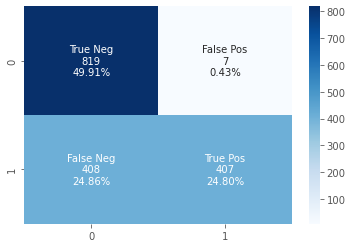

In [309]:
#correlation Matrix Heatmap
# code from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
cf_matrix_svm_und = confusion_matrix(yd_test, fselect_ypred_svm_und)

group_names_svm_und = ['True Neg','False Pos','False Neg','True Pos']

group_counts_svm_und = ["{0:0.0f}".format(value) for value in
                cf_matrix_svm_und.flatten()]

group_percentages_svm_und = ["{0:.2%}".format(value) for value in
                     cf_matrix_svm_und.flatten()/np.sum(cf_matrix_svm_und)]

labels_svm_und = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names_svm_und,
              group_counts_svm_und,
              group_percentages_svm_und)]

labels_svm_und = np.asarray(labels_svm_und).reshape(2,2)

sns.heatmap(cf_matrix_svm_und, annot=labels_svm_und, fmt='', cmap='Blues');

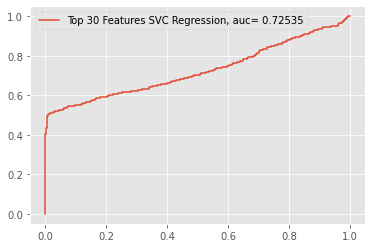

In [310]:
#ROC Curve
tuned_fselect_svc_und_ypred_proba = fselect_svc_und_pipe.predict_proba(Xd_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(yd_test,  tuned_fselect_svc_und_ypred_proba)
tuned_fselect_svc_und_auc = metrics.roc_auc_score(yd_test, tuned_fselect_svc_und_ypred_proba)
plt.plot(fpr,tpr,label="Top 30 Features SVC Regression, auc= "+str(round(tuned_fselect_svc_und_auc,5)))
plt.legend(loc=0)
plt.show();

***

# Logistic Regression & SVM Advantages:

**The advantages of using Logistic Regression for classification are:**
1. Logistic regression coefficients are easy to interpret and explain.
2. Logistic regression performs well when data are linearly separable.
3. Logistic regression can extend to predict multiple classes.
4. Logistic regression coefficients provide explanation for feature importances of variables. <br>

**The advantage of using SVMs for classification are:**
1. SVMs can handle high dimensional data.
2. SVMs are good at classifying data points that are difficult to differentiate.
3. SVMs are effective at finding the optimal hyperplane between two classes.
4. SVMs are useful if the distribution of your data is unknown or if the data is not normally distributed. <br>

SVM offers superior performance over logistic regression in terms of prediction accuracy. This is because SVMs work to find the optimal hyperplane between data classes, while logistic regression does not. Finding the optimal hyperplane reduces error and reduces the risk of overfitting models, resulting in a more accurate model.
In terms of training time, logistic regression outperforms SVM. Due to the fact that SVM is finding and saving the optimal hyperplane for the entire data set, training time will be greater than logistic regression.
For this lab, our team’s logistic regression model outperformed our SVM model. We recognize that our logistic regression model could be overfitting on our data set, however, given that we performed feature selection and removed highly correlated variables, we will accept the higher accuracy obtained by our logistic regression model.

***

# Logistic Regression Weights Analysis

**Now that we have finalized our logistic regression we can interpret the weights placed upon each feature by our model.**

>The feature given the highest importance was "cancelled"; the model has stated that holding when all other features are constant the log odds of our response being true for a cancelled flight is 5.386 times the log odds of a non-cancelled flight. In a practical sense, this means that a cancelled flight has 218.365 times the odds of being delayed as a non-cancelled flight.

>The next highest is "airline_delay" with a weight of 1.872. Thus the odds of a flight being delayed when there is a higher airline delay, and all other features are constant, is 6.501 times the odds of a flight being delayed when there are lower airline delays.
The third highest feature is "diverted" with a weight of 1.679. The odds of a flight being delayed when said flight is diverted, and all other features are constant, is 5.359 times the odds of a flight that was not diverted.

>The feature "late_aircraft_delay" with 1.144. The odds of a flight being delayed when an aircraft is late, and all other features are constant, is 3.140 times the odds of a flight without a late aircraft.

>Finally the feature "wheels_on" with 0.964. The odds of a flight being delayed when a flight has a later wheels on time, and all other features are constant, is 2.623 times the odds of a flight with an earlier time.

**In order to provide a deeper look into our model we will also interpret the 5 features that have the biggest negative impact on our model.**

>The feature "longitude_destination" had a weight of -0.259. The odds of a flight being delayed when flying to a lower  longitude is 0.772 times the odds when flying to a higher longitude.

>The one hot encoded feature of "airport_destination_George Bush Intercontinental" had a weight of -0.322. The odds of a flight being delayed while going into George Bush Intercontinental is .725 times the odds of being delayed going elsewhere.

>The one hot encoded feature of "airport_destination_IAH" had a weight of -0.322. The odds of a flight being delayed while going into IAH is .725 times the odds of being delayed going elsewhere.

>The one hot encoded feature of "tail_number_N639MQ" had a weight of -0.369. The odds of a flight being delayed while using the plane with tail number N639MQ is 0.692 times the odds when using another plane.

**Note:** 'airport_destination_IAH' and 'airport_destination_George Bush Intercontinental Airport' are the same airport. Therefore the coefficents are the same and in further model updates, we will need to remove one of the features before one hot encoding to no have this issue in the future**

> Certain variables have higher weights due to the high correlation with the repsonse variable. An example of this is the cancelled variable, as if a flight is cancelled it is therefore delayed. We recognize that having multicollinear varaibles can negatively influece model results. However, performing PCA to reduce the multidimensionality of the feautures did not make sense as this exceeded the compute powers of our personal computers.

***
### <font color = 'Green'>Tuned Logistic Regression Correlation Coefficients<font>
***

In [246]:
#https://www.geeksforgeeks.org/create-pandas-dataframe-from-lists-using-zip/
feature_names = tuned_fselect_lr_pipe[:-1].get_feature_names_out()
coefs = tuned_fselect_lr_pipe.named_steps['logistic'].coef_

In [251]:
coef_list = list(zip(coefs[0],feature_names))
df_coef_lr = pd.DataFrame(coef_list,columns = ['Coefficients','Feature']).sort_values(by='Coefficients',ascending = False)

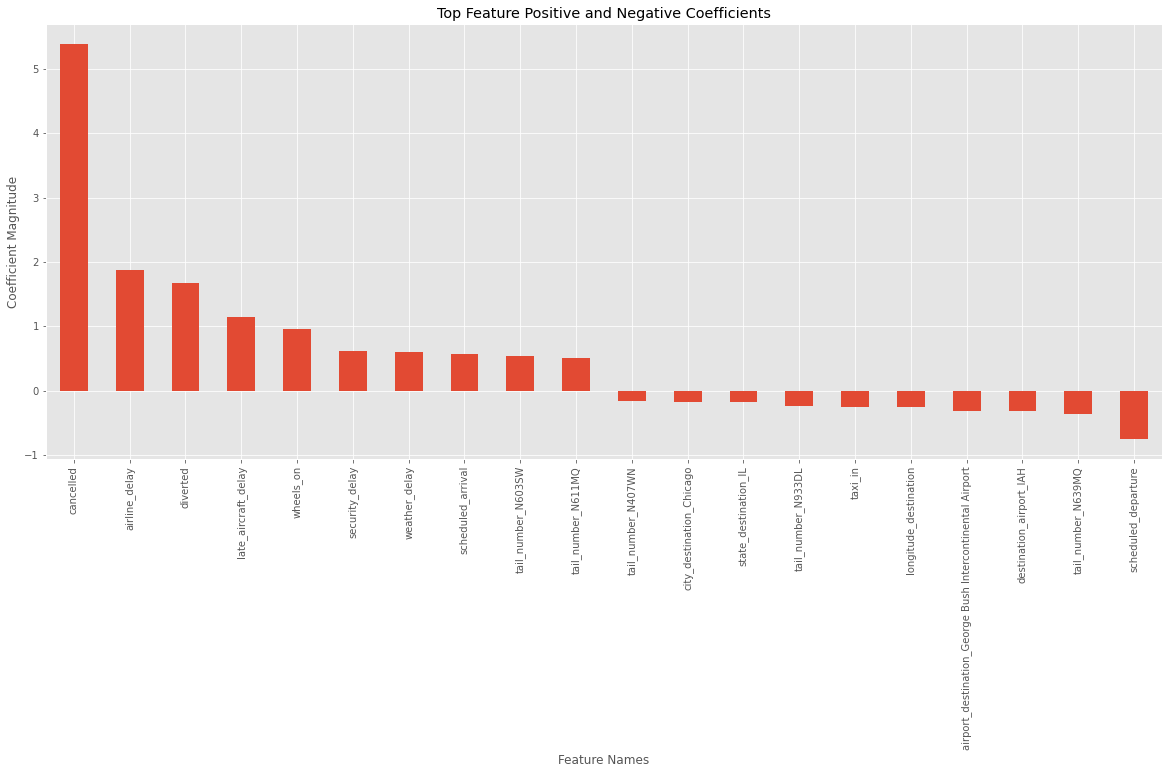

In [249]:
# altered from https://nbviewer.org/github/jakemdrew/EducationDataNC/blob/master/2017/Models/2017GraduationRates4yr.ipynb

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

coef_lr_plt_head = df_coef_lr.head(10)

coef_lr_plt_tail = df_coef_lr.tail(10)

coef_lr_plt = pd.concat([coef_lr_plt_head,coef_lr_plt_tail])

coef_lr = pd.Series(coef_lr_plt['Coefficients'].values,index=coef_lr_plt['Feature'])
ax = coef_lr.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Positive and Negative Coefficients")
ax.set_ylabel("Coefficient Magnitude")
ax.set_xlabel("Feature Names")
plt.show()

# SVM Support Vectors Analysis

    
> The support vectors show us that continuous variables with many unique records are more difficult to classify than continuous variables with a limited number of records, or binary variables. An example of this is shown in the support vector visualizations of “wheels_on” and “scheduled_time.” “wheels_on” is a continuous variable with many unique records. As shown in the original support vector, classifying this variable has a high degree of error. This is to be expected because there are many unique values for the variable. Conversely, the “scheduled_time” variable support vector visualization shows a small degree of error. This makes sense because there is a smaller range of possible values for the column.
    
> Simply put, variables that have a lot of different distinct values will be harder to classify than varibales with fewer distinct values.

***
### <font color = 'Green'>Tuned SVC Support Vectors<font>
>We plotted the first 2 support vectors chosen by SVM and then picked several other variables within our data set to plot. You can find those visualizations below.
***

In [300]:
# updated code from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
# Get support vectors themselves
support_vectors = tuned_fselect_svc_pipe.named_steps['SVM'].support_vectors_
print(support_vectors.shape)
support = tuned_fselect_svc_pipe.named_steps['SVM'].support_
print(support.shape)
n_support = tuned_fselect_svc_pipe.named_steps['SVM'].n_support_
print(n_support)

(4083, 532)
(4083,)
[2032 2051]


In [301]:
df_tested_on = X_train.copy()

In [302]:
df_support_fin = df_tested_on.iloc[tuned_fselect_svc_pipe.named_steps['SVM'].support_].copy()

In [303]:
df_support_fin['is_delay'] = y_train.iloc[tuned_fselect_svc_pipe.named_steps['SVM'].support_]
df_imputed = df_air.copy()

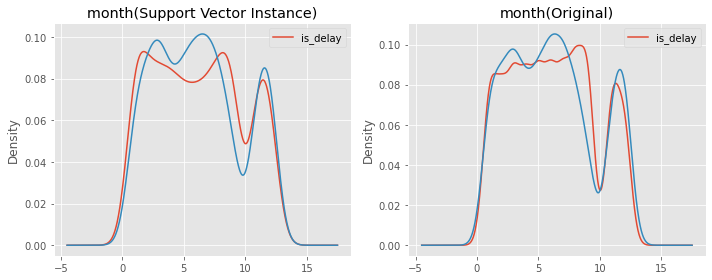

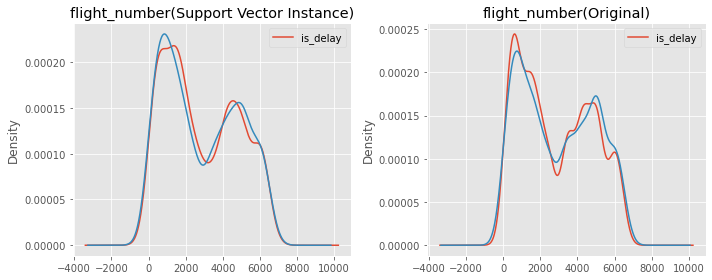

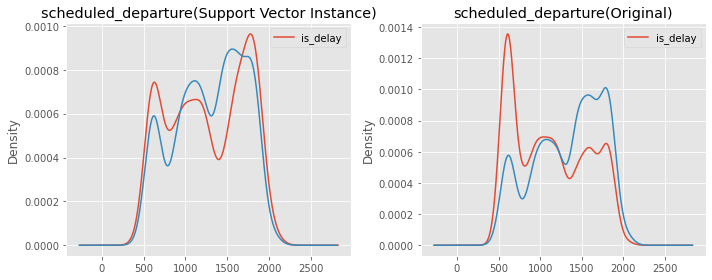

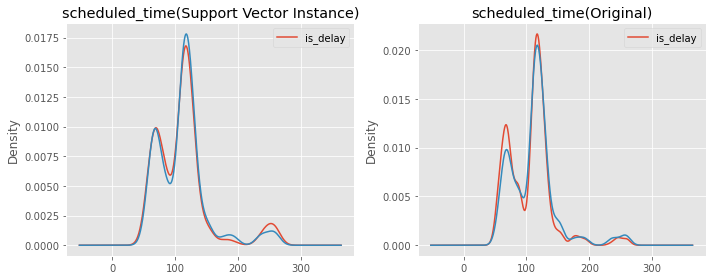

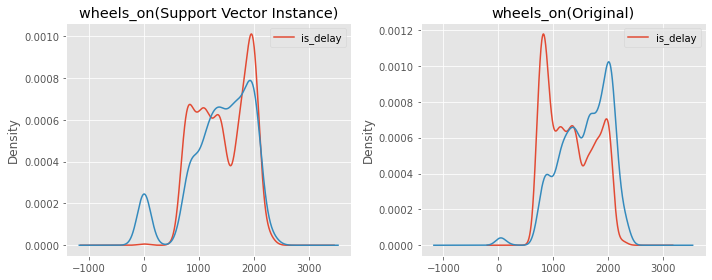

In [322]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support_fin.groupby(['is_delay'])
df_grouped = df_imputed.groupby(['is_delay'])

# plot KDE of Different variables
vars_to_plot = ['month','flight_number','scheduled_departure','scheduled_time','wheels_on']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    plt.tight_layout
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['is_delay'])
    plt.title(v+'(Support Vector Instance)')
    plt.tight_layout()
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['is_delay'])
    plt.title(v+'(Original)')
    plt.tight_layout()